# <div style="padding:20px;color:white;margin:0;font-size:200%;text-align:center;display:fill;border-radius:5px;background-color:#AF601A;overflow:hidden;font-weight:500">TPS June 2022
</div>




 ### If you are a beginner, see my other notebook for imputation tutorial [notebook](https://www.kaggle.com/code/abdulravoofshaik/quick-eda-and-missing-values-tutorial). 
 ### The following cartoon depicts the overall framework for applying advanced regression technique for imputation.


<img src="https://i.postimg.cc/90BdtTjq/imputer.gif">



<div style="color:white;display:fill;border-radius:8px;
            background-color:#E59866;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:black;"><b>1.0 | Load data and Preprocessing</b></p>
</div>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import missingno as msno
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [2]:
data = pd.read_csv("../input/tabular-playground-series-jun-2022/data.csv")
Target = pd.read_csv("../input/tabular-playground-series-jun-2022/sample_submission.csv", index_col='row-col')

In [3]:
# get the number of missing data points per column
missing_values_count = data.isnull().sum()
# look at the # of missing points in the first ten columns
missing_values_count[0:30]

row_id        0
F_1_0     18397
F_1_1     18216
F_1_2     18008
F_1_3     18250
F_1_4     18322
F_1_5     18089
F_1_6     18133
F_1_7     18128
F_1_8     18162
F_1_9     18249
F_1_10    17961
F_1_11    18170
F_1_12    18203
F_1_13    18398
F_1_14    18039
F_2_0         0
F_2_1         0
F_2_2         0
F_2_3         0
F_2_4         0
F_2_5         0
F_2_6         0
F_2_7         0
F_2_8         0
F_2_9         0
F_2_10        0
F_2_11        0
F_2_12        0
F_2_13        0
dtype: int64

In [4]:
# how many total missing values do we have?
total_cells = np.product(data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
(total_missing/total_cells) * 100

1.2345679012345678

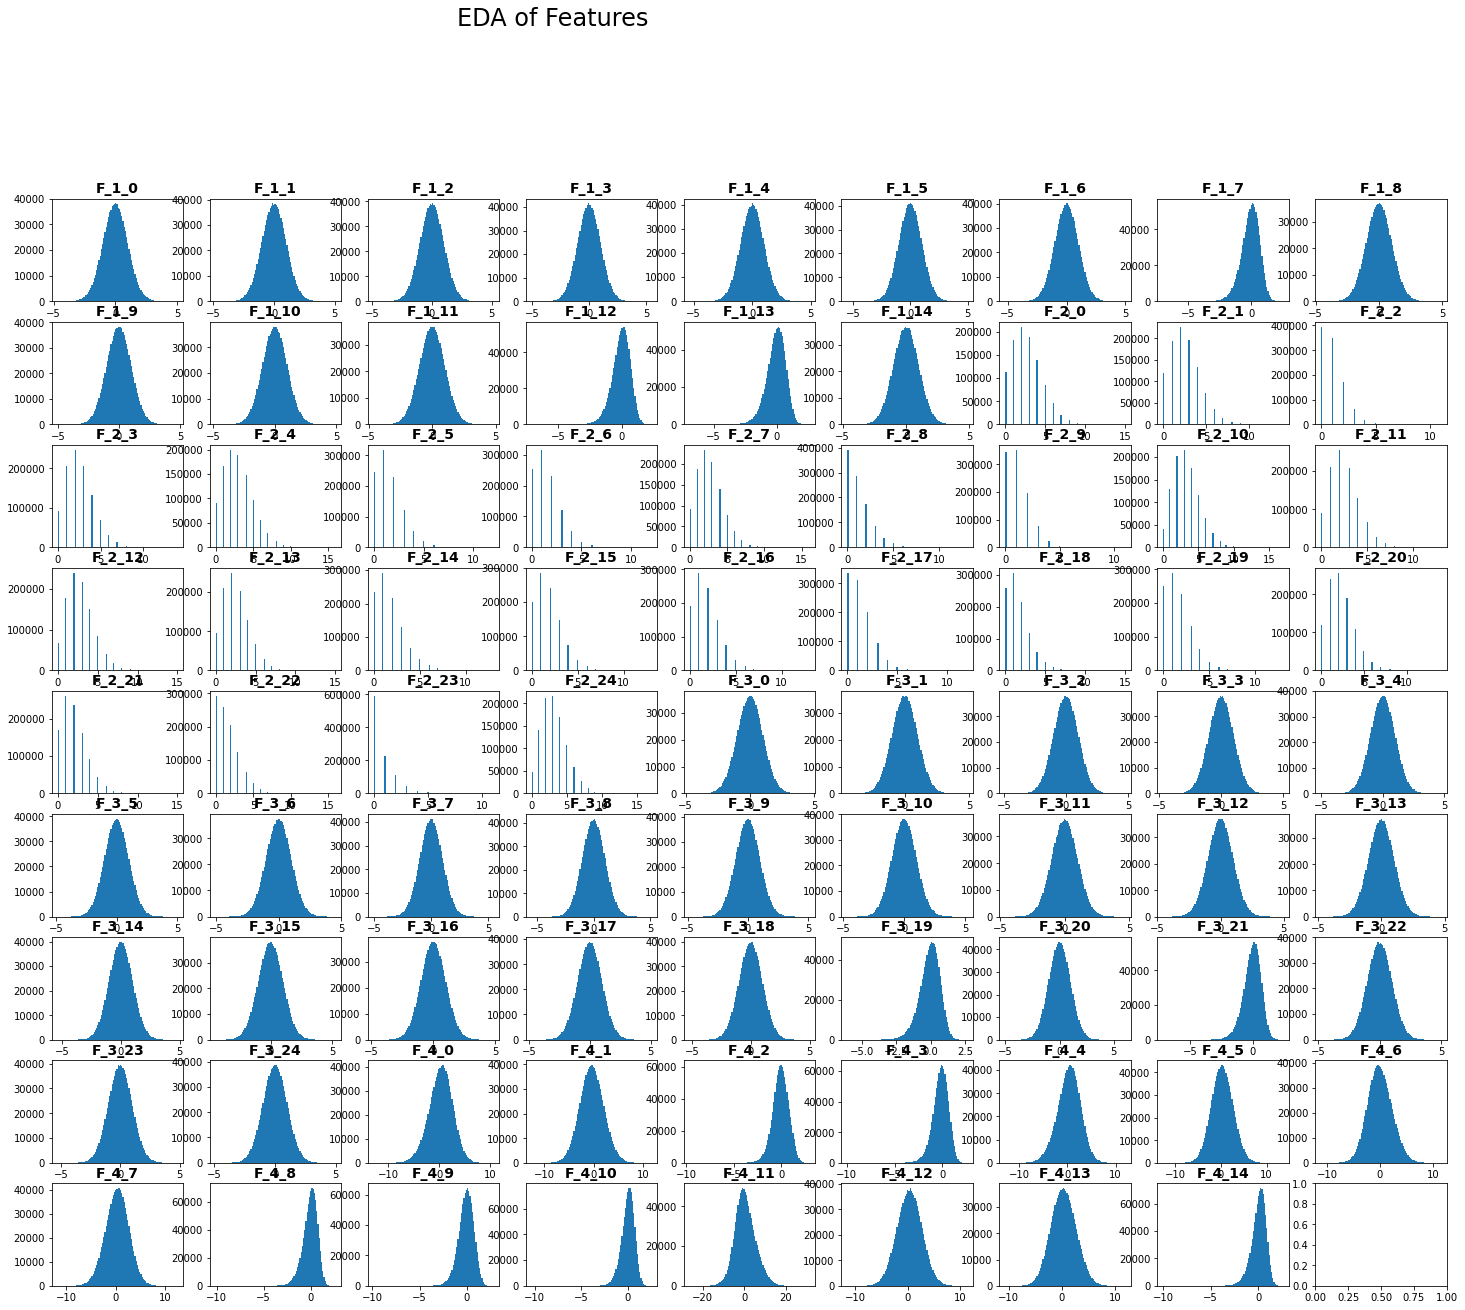

<Figure size 1800x1440 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt #data viz
# v Sets matplotlib figure size defaults to 25x20
plt.rcParams["figure.figsize"] = (25,20)

fig, ax = plt.subplots(#This functions lets us place many plots within a single figure
    9, #number of rows
    9  #number of columns
)

#adds title to figure            
fig.text(
    0.35, # text position along x axis
    1, # text position along y axis
    'EDA of Features', #title text
    {'size': 24} #Increase font size to 35
         )

i = 0 # subplot column index
j = 0 # subplot row index
for col in data.columns: #iterate thru all dataset columns
    if col not in ['row_id']: 
        ax[j, i].hist(data[col], bins=100) #plots histogram on subplot [j, i]
        ax[j, i].set_title(col, #adds a title to the subplot
                           {'size': '14', 'weight': 'bold'}) 
        if i == 8: #if we reach the last column of the row, drop down a row and reset
            i = 0
            j += 1
        else: #if not at the end of the row, move over a column
            i += 1

plt.rcParams.update({'axes.facecolor':'lightgreen'})
plt.figure(facecolor='red') 
plt.show() 


<div style="color:white;display:fill;border-radius:8px;
            background-color:#E59866;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:black;"><b>2.0 | Preprocessing</b></p>
</div>

### Lets start with column F_1_0 and try to replace the NaN values. First we need to find out where are the missing values located in this column. As shown below figure, we need to split our data into two sets. 
### Training set: It consists of known values for F_1_0 column, which means all the rows with non-NaN value in F_1_0 column. 
### Test set: It consists of Unknown values for F_1_0 column, which means all the rows with  NaN value in F_1_0 column.
### we apply the same concept to individual column and develop 80 individual models. Missing vlaue plot and correlation plots are shown below


<AxesSubplot:>

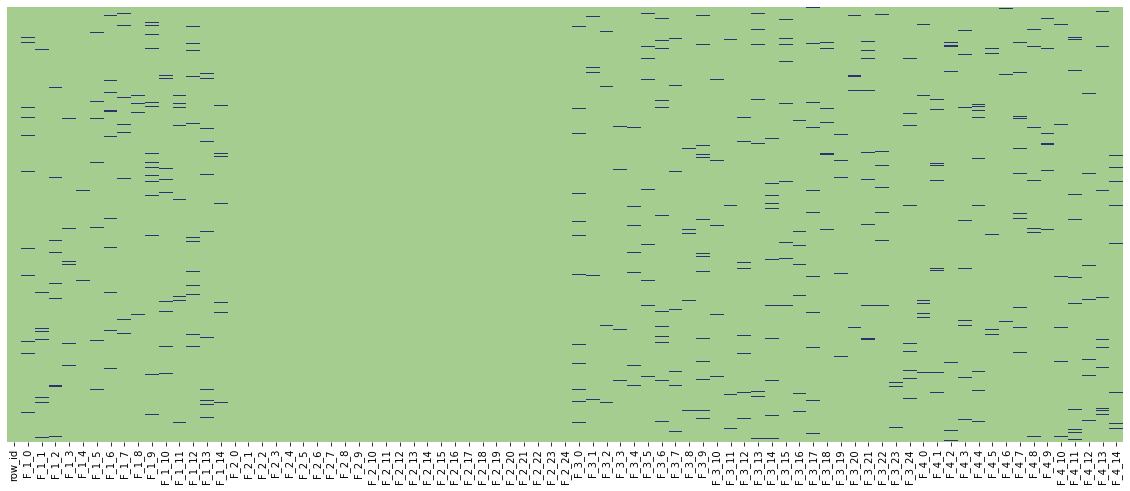

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import seaborn as sns
plt.figure(figsize=(20,8))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='crest')

### As we can see above plot, there are not missing values for columns starting with F_2

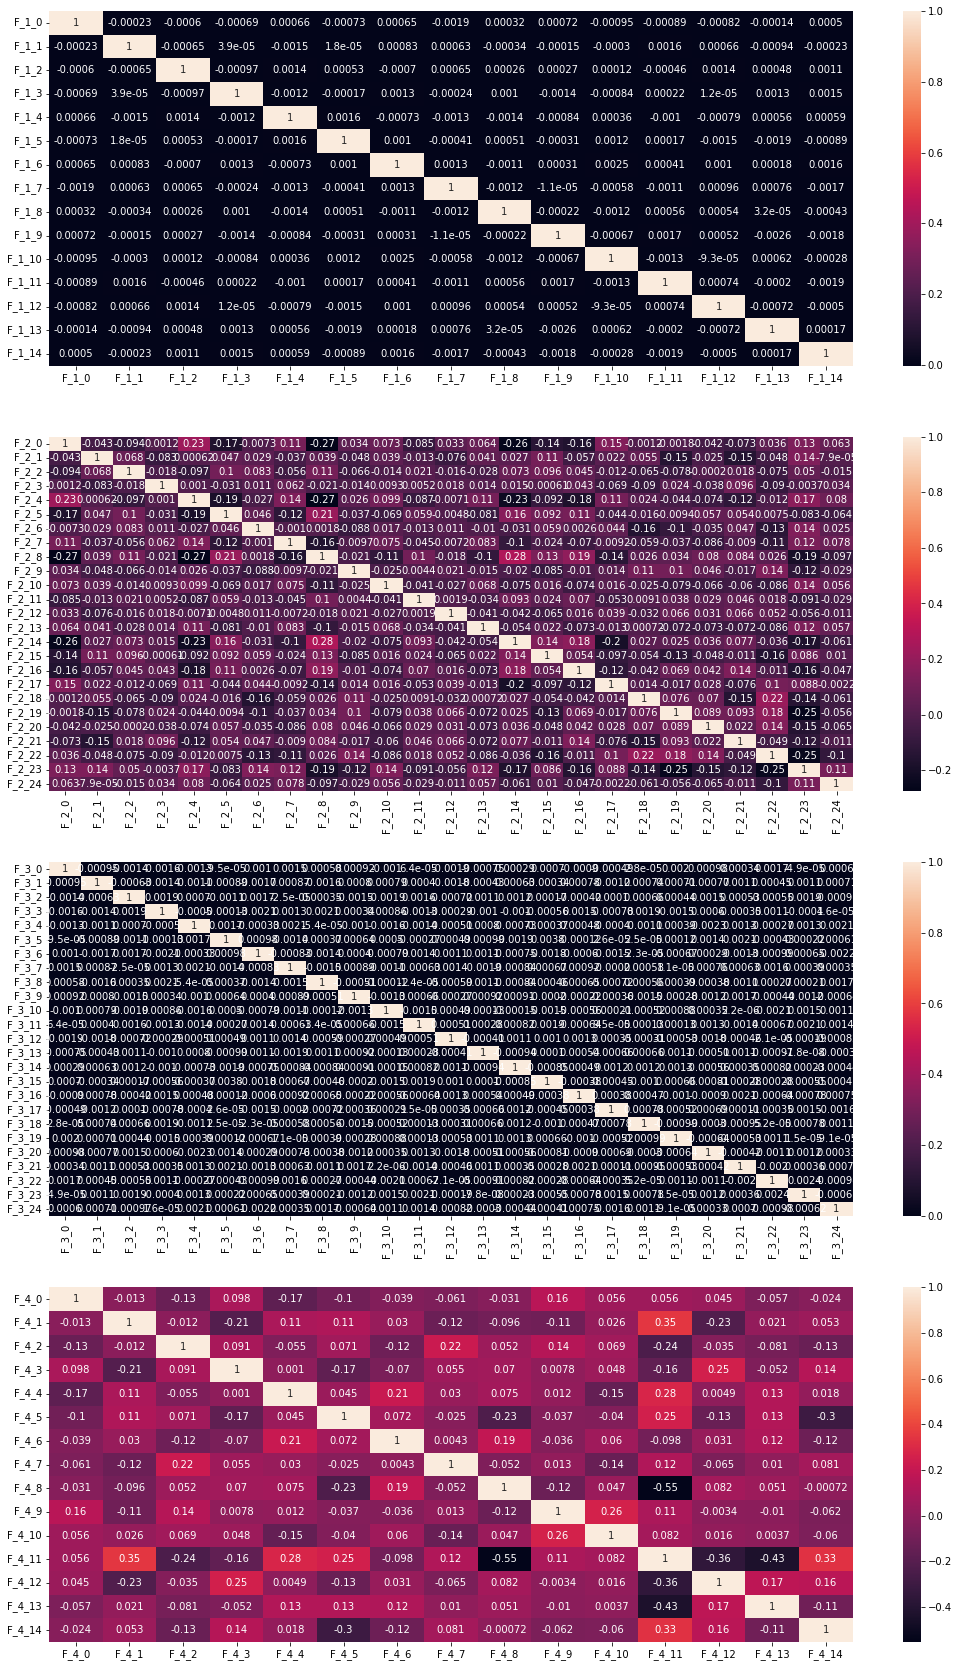

In [7]:
## we apply the same concept to individual column and develop 80 individual models. As we have noticed earlier, dataset has four different subsets. Lets divide them.
# this code snippet is taken from https://www.kaggle.com/code/martynovandrey/tps-jun-22-splitted-dataset-24x-faster. Consider upvoting the original author also
features = list(data.columns)
features_1, features_2, features_3, features_4 = [], [], [], []
F = [[], [], [], [], []]
for feature in features:
    for i in [1, 2, 3, 4]:
        if feature.split('_')[1] == str(i):
            F[i].append(feature)
df = [[], [], [], [], []]

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18, 30))

for i in [1, 2, 3, 4]:
    df[i] = data[F[i]]
    corr = df[i].corr()
    sns.heatmap(corr, ax=axs[i-1], annot=True)

### Columns starting with F_4 are correlated with each other, we do not see such pattern in other subsets.

In [8]:
# lets take look at one of the subset
df[4].head(2)


,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775


In [9]:
# get the number of missing data points per column in this subset
missing_values_count = df[4].isnull().sum()
missing_values_count [0:30]

F_4_0     18128
F_4_1     18164
F_4_2     18495
F_4_3     18029
F_4_4     17957
F_4_5     18063
F_4_6     18325
F_4_7     18014
F_4_8     18176
F_4_9     18265
F_4_10    18225
F_4_11    18119
F_4_12    18306
F_4_13    17995
F_4_14    18267
dtype: int64

<div style="color:white;display:fill;border-radius:8px;
            background-color:#E59866;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:black;"><b>3.0 | Modeling</b></p>
</div>

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana;">
    📌 Important note: Based on the correlation plot it can be seen that subset-four (start with F_4_) has good correlation with each other. Rest of the subsets are weekly correlated.<br>
    The strategy is use LGBM regression for subset-4 and mean regression for rest of the subsets.
</div>

In [10]:
%%time
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
for i in [4]:
    dummy_df = pd.DataFrame()
    dummy_df2 = pd.DataFrame()
    col_train = pd.DataFrame()
    col_test = pd.DataFrame()
    dummy_df=df[i].copy()
    dummy_df2=df[i].copy()
    for column in dummy_df.columns: 
        print('Processing Column Name : ', column)
        if dummy_df[column].isnull().sum() == 0:
            print(dummy_df[column].isnull().sum())
            continue    # continue as no NaN values found in this column
        col_nan_ix = dummy_df[dummy_df[column].isnull()].index  # identify the rows which has NaN in column
        col_train = dummy_df.drop(col_nan_ix, axis = 0)  #training set which has column fixed value but other columns might have NaN values
        col_test = dummy_df[dummy_df.index.isin(col_nan_ix)] 
        X = col_train.drop([column],axis=1)[:10000]
        y = col_train[column][:10000]
        if column in ['F_4_0', 'F_4_1', 'F_4_6']:
            print("hard mode on for column ", column)
            model = LGBMRegressor(n_estimators=40000,metric='rmse')
        else:
            model = LGBMRegressor(n_estimators=20000,metric='rmse')
        model.fit(X,y)
#        score=model.score(X, y)
#        print('R2 of this column : ', score)
        dummy_df2[column][col_nan_ix] = model.predict(col_test.drop([column],axis=1))
    df[i]=dummy_df2.copy()

Processing Column Name :  F_4_0
hard mode on for column  F_4_0
Processing Column Name :  F_4_1
hard mode on for column  F_4_1
Processing Column Name :  F_4_2
Processing Column Name :  F_4_3
Processing Column Name :  F_4_4
Processing Column Name :  F_4_5
Processing Column Name :  F_4_6
hard mode on for column  F_4_6
Processing Column Name :  F_4_7
Processing Column Name :  F_4_8
Processing Column Name :  F_4_9
Processing Column Name :  F_4_10
Processing Column Name :  F_4_11
Processing Column Name :  F_4_12
Processing Column Name :  F_4_13
Processing Column Name :  F_4_14
CPU times: user 1h 8min 43s, sys: 39.7 s, total: 1h 9min 23s
Wall time: 17min 44s


In [11]:
# lets take a quick look at the subset-4
df[4].head()

,F_4_0,F_4_1,F_4_2,F_4_3,F_4_4,F_4_5,F_4_6,F_4_7,F_4_8,F_4_9,F_4_10,F_4_11,F_4_12,F_4_13,F_4_14
0,5.547214,1.066871,-0.134313,-0.101040,-0.660871,3.744152,0.794438,0.265185,-0.561809,0.196480,0.373434,6.206995,3.809505,1.236486,1.182055
1,-1.707374,-1.188114,-0.562419,-1.462988,1.290672,-2.895826,-0.738275,2.361818,-0.060753,0.727249,-0.271882,5.232157,-4.218259,-2.724883,-0.063775
2,1.914908,3.877128,0.483769,0.358635,0.443973,2.252834,0.472496,2.491386,0.353381,-0.260682,-0.000833,-0.116457,-2.131747,3.661499,-0.131576
3,-2.638262,0.546676,0.865400,-0.857077,2.667105,2.004600,-4.664806,-0.847211,-0.264249,0.664334,-0.557868,8.499483,-4.738799,-3.054611,0.494152
4,-0.230342,-0.459019,1.128705,-0.748683,0.011758,0.976937,2.558883,3.377724,0.846891,0.696032,0.554121,-5.979714,-2.869631,3.733057,-0.722943


### Now we use simple meanimputer for subset-1 and subset-3. Note that subset-2 has no missing values

In [12]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(
        missing_values=np.nan,
        strategy='mean') 
for i in [1,3]:    
    df[i][:] = imp.fit_transform(df[i])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipyk

In [13]:
Merged_Subsets = pd.concat([df[1], df[2], df[3], df[4]], axis=1)
submission = pd.read_csv('../input/tabular-playground-series-jun-2022/sample_submission.csv', index_col='row-col')
for i in tqdm(submission.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    submission.loc[i, 'value'] = Merged_Subsets.loc[row, col]

submission.to_csv('submission.csv')

100%|██████████| 1000000/1000000 [02:04<00:00, 8059.74it/s]


## The LB is 0.88208, top 2% as of now.

<img src="https://31.media.tumblr.com/tumblr_lptgqw2SE81qj2mh7o1_500.gif">

<div style="color:white;display:fill;border-radius:8px;
            background-color:#E59866;font-size:150%;
            font-family:Nexa;letter-spacing:0.5px">
    <p style="padding: 8px;color:black;"><b>3.0 | References</b></p>
</div>

https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009 <br>
https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4 <br>
https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python/notebook <br>
https://www.kaggle.com/code/residentmario/using-missingno-to-diagnose-data-sparsity/notebook <br>
https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/ <br>
https://www.kaggle.com/code/calebreigada/getting-started-eda-preprocessing <br>
https://medium.com/swlh/impute-missing-values-the-right-way-c63735fccccd <br>

